### Milestone 4: Deep learning, due Wednesday, April 26, 2017

You can try different architectures, initializations, parameter settings, optimization methods, etc. Be adventurous and explore deep learning! It can be fun to combine the features learned by the deep learning model with a SVM, or incorporate meta data into your deep learning model. 

The notebook to submit this week should at least include:

- Complete description of the deep network you trained from scratch, including parameter settings, performance, features learned, etc. 
- Complete description of the pre-trained network that you fine tuned, including parameter settings, performance, features learned, etc. 
- Discussion of the results, how much improvement you gained with fine tuning, etc. 
- Discussion of at least one additional exploratory idea you pursued

In [1]:
import urllib2
import PIL
import os
import numpy as np
import math

# for image manipulation. Easier to do 
# here than with Keras, as per
# https://piazza.com/class/ivlbdd3nigy3um?cid=818
#!sudo pip install Image
import PIL.Image as Image
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten

Using TensorFlow backend.


## Step One: Extracting Movies From URL 

In [3]:
# train = pd.read_csv("train_full.csv")
# train.drop("Unnamed: 0", axis=1, inplace=True)
# print "Train shape:", train.shape
# train.head(1)

In [4]:
train_thinned = pd.read_csv("train.csv")
train_thinned.drop("Unnamed: 0", axis=1, inplace=True)
print "train_thinned shape:", train_thinned.shape
train_thinned.head(1)

train_thinned shape: (540, 29)


,10402,10749,10751,10752,12,14,16,18,27,28,...,lead actors,movie_id,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,0,0,1,0,0,0,1,0,0,0,...,"[u'Alec Baldwin', u'Miles Bakshi', u'Jimmy Kim...",295693,A story about how a new baby's arrival impacts...,305.881041,/unPB1iyEeTBcKiLg8W083rlViFH.jpg,2017-03-23,The Boss Baby,False,5.7,510


## Important. 

The line below aliases the DF that we want to work with as `curr_df`. When we decide later on to use the full training set instead of just `train_thinned`, all we need to do is set it in the cell below and re-run the code. This will prevent us from having to find/replace all instances of the past dataframe.

In [5]:
curr_df = train_thinned

In [6]:
## Helper that downloads web images 
## Takes in the poster path and the id of the movie 
## Saves the movie as a jpg as the unique id of the movie 
## In the images folder.
def download_web_image(poster_path, movie_id):
    # given that we're going to resize our images to be 32x32
    # or something else really small, let's download really small images 
    # to start
    base_url = "https://image.tmdb.org/t/p/w92/" 
    
    request = urllib2.Request(base_url + poster_path)
    img = urllib2.urlopen(request).read()
    image_name= "images/" + str(movie_id) + ".jpg"
    
    with open(image_name, 'w') as f: 
        f.write(img)

In [7]:
### iterate through all of the images in the thinned dataset, saving locally 
if 1:
    print "If you actually want to download posters, you'll need to turn the `1` above into a `0`. This code doesn't run by default in the notebook so that you don't accidentally download hundreds of images."
else:
    for index, row in curr_df.iterrows():
        movie_id = row["movie_id"]
        poster_path = row["poster_path"] 
#         download_web_image(poster_path, movie_id)

If you actually want to download posters, you'll need to turn the `1` above into a `0`. This code doesn't run by default in the notebook so that you don't accidentally download hundreds of images.


In [8]:
img_rows, img_cols = 32, 32

# convert each normal poster to a 32x32 grayscale poster
for img_name in os.listdir("images/"):
    ## This line added to avoid hidden files on mac (Stephen)
    if not img_name.startswith('.'):
        # read in an image and convert to greyscale
        im = Image.open("images/" + img_name).convert("L")
        out = im.resize((img_rows, img_cols))
        out.save("nn_ready_images/" + img_name)

# 1. Building a CNN from Scratch

In [9]:
epochs = 30
batch_size = 128

### Data Wrangling

In [10]:
# number of labels in our output
n_labels = 17

In [11]:
# now we need training and testing data. in the current state,
# we have a bunch of greyscale images named by their movie ids.
# to get the data, we can first just split all the movie ids (X) in the
# dataframe intro train and test sets, and then grab their multilabel
# matrices (y)
m_ids = curr_df.movie_id.values

# shuffle the ids to get a random sample
np.random.shuffle(m_ids)
train_size = int(math.floor(.7 * len(m_ids)))

# get the movie_ids (each of which has an image in "nn_images_ready/"
# which is ready to be put through the neural net
train_ids = m_ids[:train_size]
test_ids = m_ids[train_size:]

In [12]:
# these are the column names of the multilabel matrix
label_names = curr_df.columns[:n_labels]

y_train = np.array([curr_df[curr_df.movie_id == movie_id][label_names].values[0] for movie_id in train_ids])
y_test  = np.array([curr_df[curr_df.movie_id == movie_id][label_names].values[0] for movie_id in test_ids])

# should be (num_samples, num_labels)
print "y_train shape:", y_train.shape
print "y_test shape:", y_test.shape

y_train shape: (378, 17)
y_test shape: (162, 17)


In [13]:
# smaller batch size means noisier gradient, but more updates per epoch
# batch_size = 512

# number of iterations over the complete training data
# epochs = 30

In [14]:
# load image matrices into memory
x_train = np.array([np.asarray(Image.open("nn_ready_images/" + str(m_id) + ".jpg")) for m_id in train_ids])
x_test =  np.array([np.asarray(Image.open("nn_ready_images/" + str(m_id) + ".jpg")) for m_id in test_ids])

In [15]:
# output should be (num_images, img_height, img_width)
print "x_train shape:", x_train.shape
print "x_test shape:", x_test.shape

x_train shape: (378, 32, 32)
x_test shape: (162, 32, 32)


In [16]:
# code borrowed from Keras_CNN lab

# now we need to reshape x_train and x_test so that they work with CNNs
# Following the example in "labs/Keras_CNN.ipynb", this needs to be an array 
# of images with shape determined by the backend, including the depth dimension,
# which is 1 for greyscale

# x_train is of shape n_samples x 32 x 32
# for a CNN we want to keep the image shape
# need to explicitly tell keras that it is a gray value image
# so each image is 32x32x1 not 32x32x3
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
# normalize image values to [0,1]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print "x_train shape:", x_train.shape
print x_train.shape[0], "train samples"
print x_test.shape[0], "test samples"

x_train shape: (378, 32, 32, 1)
378 train samples
162 test samples


### Model Architecture

In [17]:
def CNN_from_scratch(n_layers, filters, kernels, activation_function):
    """
    Wrapper function to create a CNN from scratch.
    
    We treat the number of layers, filter size, kernel size, and activation 
    function as parameters which can then be tuned.
    """
    # create an empty network model
    model = Sequential()
    
    for i in n_layers:
        # define the input layer to the CNN
        # input shape is a tuple of the # rows, # cols, and # channels (1 for grayscale)
        # the first parameter to Conv2D is the number of filters we want to convolve
        # over the input images
        model.add(Conv2D(filters[i], 
                         kernel_size=kernels[i], 
                         activation=activation_function, 
                         input_shape=input_shape)
                 )

        # create a max pooling layer
        model.add(MaxPooling2D(pool_size=(2, 2)))

    # flatten for fully connected classification layer
    model.add(Flatten())

    # --- fully connected layer ---
    model.add(Dense(64, activation='relu'))

    # recommended by: https://github.com/fchollet/keras/issues/761
    # uses a sigmoid activation rather than softmax, which apparently
    # gives us a label vector back
    model.add(Dense(n_labels, activation='sigmoid'))

    # prints out a summary of the model architecture
    model.summary()

    # the setup is our basic categorical crossentropy with stochastic gradient decent
    # we also specify that we want to evaluate our model in terms of accuracy
    sgd = SGD(lr=0.1, momentum=0.9)

    # compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

    # this is now the actual training
    # in addition to the training data we provide validation data
    # this data is used to calculate the performance of the model over all the epochs
    # this is useful to determine when training should stop
    # in our case we just use it to monitor the evolution of the model over the training epochs
    # if we use the validation data to determine when to stop the training or which model to save, we 
    # should not use the test data, but a separate validation set. 
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
    
    # once training is complete, let's see how well we have done
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    return score

In [18]:
model_iter_1 = CNN_from_scratch(n_layers=range(1), filters=[8], kernels=[(3, 3)], activation_function='relu')[0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1800)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                115264    
_________________________________________________________________
dense_2 (Dense)              (None, 17)                1105      
Total params: 116,449.0
Trainable params: 116,449.0
Non-trainable params: 0.0
_________________________________________________________________
Train on 378 samples, validate on 162 samples
Epoch 1/30
378/378 [==============================] - 0s - loss: 0.6853 - acc: 0.544

# Tuning our CNN from Scratch

Per this quora answer: https://www.quora.com/How-can-I-decide-the-kernel-size-output-maps-and-layers-of-CNN

### On Kernels
- For kernel size, in general, smaller + deeper kernels are better
- Deeper networks are generally better (more layers), at the cost of more data required and increased learning complexity

### On batch
- batch size should be a few hundred

### On Filters
- initially should use fewer filters and gradually increase and monitor the error rate to see how it is varying
- very small filter sizes will capture very fine details of the image, bigger filters will leave out minute details in the image
- common kernel sizes are 3x3, 5x5, and 7x7

In [19]:
# create an empty network model
model = Sequential()

# define the input layer to the CNN
# input shape is a tuple of the # rows, # cols, and # channels (1 for grayscale)
# the first parameter to Conv2D is the number of filters we want to convolve
# over the input images
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=input_shape))

# create a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add another convolution layer
# we could double the number of filters as max pool made the 
# feature maps much smaller, but we're not doing this to improve runtime
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))

# create a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# ================

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# create a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# ================

# flatten for fully connected classification layer
model.add(Flatten())

# note that the 10 is the number of classes we have
# the classes are mutually exclusive so softmax is a good choice
# --- fully connected layer ---
model.add(Dense(64, activation='relu'))

# recommended by: https://github.com/fchollet/keras/issues/761
# uses a sigmoid activation rather than softmax, which apparently
# gives us a label vector back
model.add(Dense(n_labels, activation='sigmoid'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
__________

### Compile the model

Let's use a large learning rate (0.1) while we're working locally

In [20]:
# the setup is our basic categorical crossentropy with stochastic gradient decent
# we also specify that we want to evaluate our model in terms of accuracy
sgd = SGD(lr=0.01, momentum=0.9)

# TODO: why are we using binary crossentropy?
# I'm not sure, but it works much better than
# categorical crossentropy.
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

### Train the model

In [21]:
# this is now the actual training
# in addition to the training data we provide validation data
# this data is used to calculate the performance of the model over all the epochs
# this is useful to determine when training should stop
# in our case we just use it to monitor the evolution of the model over the training epochs
# if we use the validation data to determine when to stop the training or which model to save, we 
# should not use the test data, but a separate validation set. 
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=30,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 378 samples, validate on 162 samples
Epoch 1/30
378/378 [==============================] - 0s - loss: 0.6967 - acc: 0.4077 - val_loss: 0.6949 - val_acc: 0.4259
Epoch 2/30
378/378 [==============================] - 0s - loss: 0.6934 - acc: 0.4599 - val_loss: 0.6905 - val_acc: 0.5080
Epoch 3/30
378/378 [==============================] - 0s - loss: 0.6887 - acc: 0.5557 - val_loss: 0.6861 - val_acc: 0.5984
Epoch 4/30
378/378 [==============================] - 0s - loss: 0.6840 - acc: 0.6453 - val_loss: 0.6813 - val_acc: 0.6983
Epoch 5/30
378/378 [==============================] - 0s - loss: 0.6788 - acc: 0.7319 - val_loss: 0.6762 - val_acc: 0.7607
Epoch 6/30
378/378 [==============================] - 0s - loss: 0.6732 - acc: 0.7834 - val_loss: 0.6704

In [22]:
# once training is complete, let's see how well we have done
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test loss:', 0.41680341958999634)
('Test accuracy:', 0.82897607338281321)


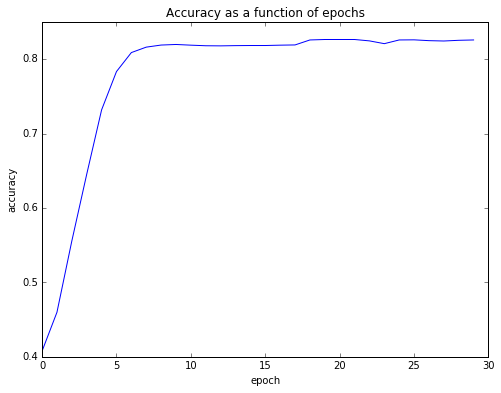

In [23]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.figure(figsize=(8, 6))
plt.plot(history.history['acc'])
plt.title("Accuracy as a function of epochs")
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [24]:
dev_set_x = x_train[:x_test.shape[0]]
dev_set_y = y_train[:y_test.shape[0]]

x_train = x_train[x_test.shape[0]:]
y_train = y_train[y_test.shape[0]:]

Batch size: 32
Test loss: 0.49407764423
Test accuracy: 0.793028345814


Batch size: 64
Test loss: 0.55436443841
Test accuracy: 0.778503991939


Batch size: 128
Test loss: 0.609849717146
Test accuracy: 0.773420495751


Batch size: 256
Test loss: 0.645660138425
Test accuracy: 0.77559915884




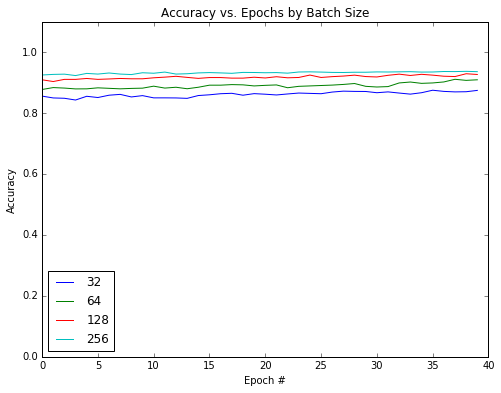

In [29]:
b_sizes = 2 ** np.arange(5, 9)

plt.figure(figsize=(8, 6))
plt.title("Accuracy vs. Epochs by Batch Size")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")


for b_size in b_sizes:
    history = model.fit(x_train, y_train,
                    batch_size=b_size,
                    epochs=40,
                    verbose=0,
                    validation_data=(x_test, y_test))

    score = model.evaluate(x_test, y_test, verbose=0)
    
    print "Batch size:", b_size
    print "Test loss:", score[0]
    print "Test accuracy:", score[1]
    print "\n"
    
    plt.plot(history.history['acc'], label=str(b_size))

plt.legend(loc="best")
plt.ylim([0, 1.1])
plt.show()